In [28]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO

# standard import
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# nf imports
from models.affine_coupling_nf import NormalizingFlow

In [29]:
plt.style.use("ggplot")

In [30]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.y[idx]

This Notebook implements an (Unconditional) Normalizing Flow model (as in RealNVP) for the two-moons dataset

### Data

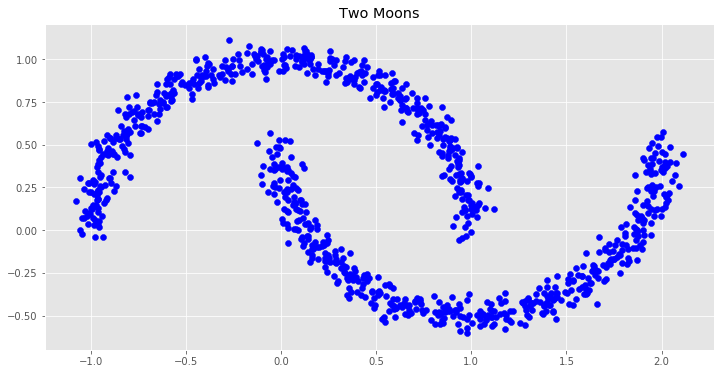

In [51]:
# Data - Two Moons
n = 1000
X = make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
X_tensor = torch.from_numpy(X)
plt.figure(figsize=(12,6))
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c="b")
plt.title("Two Moons")
plt.show()

In [33]:
# create data-iterator
dataset = Dataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000,
                        shuffle=True, num_workers=0)

In [45]:
# Build NF model
nf = NormalizingFlow(input_dim=2, split_dim=1, hidden_dim=32, num_layers=1, flow_length=10, 
                    use_cuda=False)

In [46]:
# Build SVI object
svi = SVI(nf.model, nf.guide, pyro.optim.Adam({"lr": 0.0003}), Trace_ELBO(num_particles=1))

In [47]:
print("number of params: ", sum(p.numel() for p in nn.ModuleList(nf.transforms).parameters()))

number of params:  1300


ELBO: 188.40: 100%|██████████| 10000/10000 [03:54<00:00, 42.68it/s]


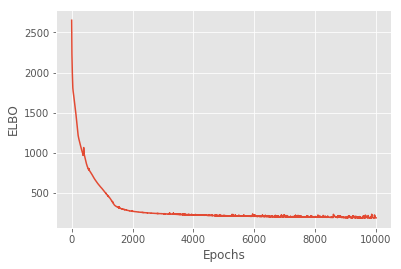

In [48]:
num_epochs = 10000
losses = []
pyro.clear_param_store()

epochs = tqdm.trange(num_epochs)
for epoch in epochs:
    try:
        running_loss = 0
        for x_batch in dataloader:
            loss = svi.step(x_batch)
            running_loss += loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("ELBO")
plt.show()

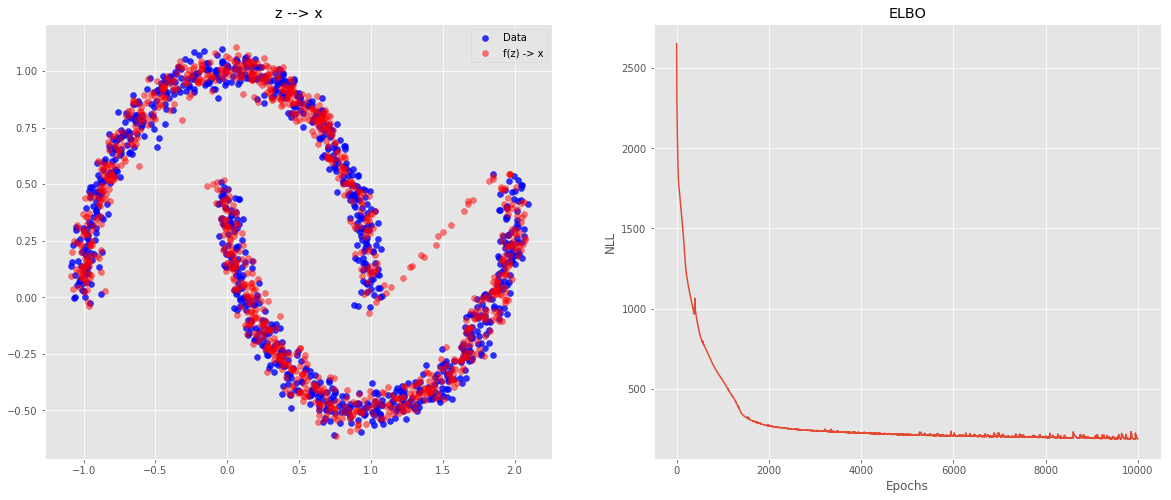

In [49]:
# Sample from trained NF
samples = nf.sample(num_samples=1000).detach()
fig = plt.figure(figsize=(20,8))
fig.add_subplot(121)
plt.scatter(X[:, 0], X[:, 1], c="b", label="Data", alpha=0.8)
plt.scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) -> x")
plt.title("z --> x")
plt.legend()
fig.add_subplot(122)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()

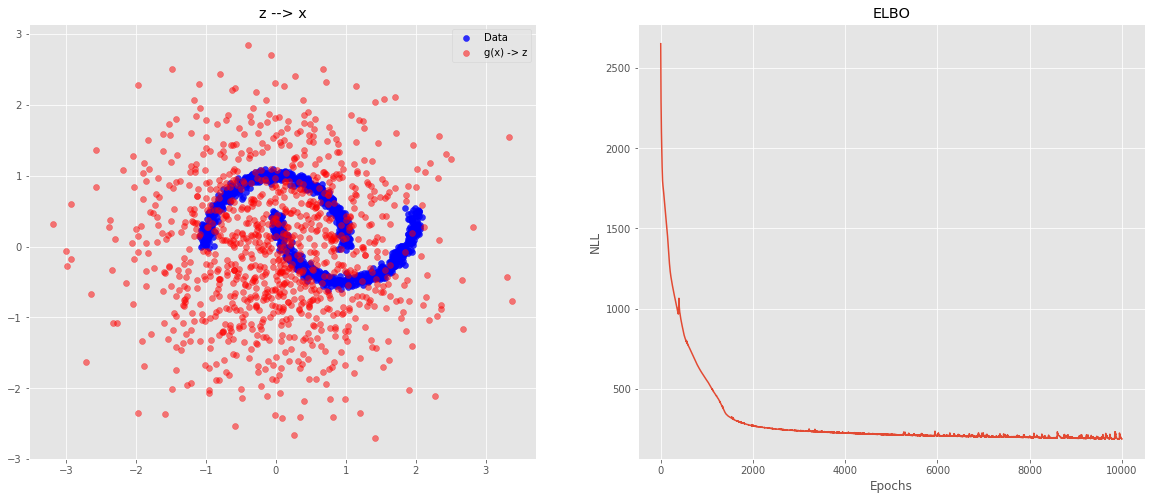

In [50]:
# Run data backward through the flow (normalizing direction)
z_prior = nf.backward(X_tensor)[1].detach()
fig = plt.figure(figsize=(20,8))
fig.add_subplot(121)
plt.scatter(X[:, 0], X[:, 1], c="b", label="Data", alpha=0.8)
plt.scatter(z_prior[:, 0], z_prior[:, 1], c="r", alpha=0.5, label="g(x) -> z")
plt.title("z --> x")
plt.legend()
fig.add_subplot(122)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()